In [1]:
!pip install nptyping==1.0.1
!pip install SciencePlots

     |████████████████████████████████| 45 kB 2.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6483 sha256=28df68a4f91bdc255727a4a0425b7dd0ae99cc588113b97c447ead835b8696d0
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


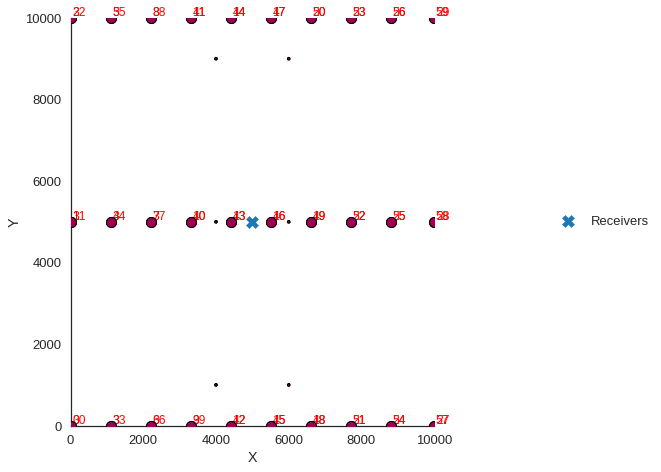

In [2]:

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

import matplotlib
# from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
from functools import reduce
import operator

sys.path.append('/content/drive/My Drive/YJ/GP_old')

sys.path.append('/content/drive/My Drive/YJ')

sys.path.append('/content/drive/MyDrive/YJ/Gravity_valid')
import matplotlib.pyplot as plt

import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
import seaborn as sns
from ThreeLayer import *
# %%

X = [5000]
Y = [5000]
# X = np.linspace(2000,8000,5)
# Y = np.linspace(3000,7000,4)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)
Z = 1000
n_devices = receivers.shape[0]

path = '/content/drive/MyDrive/YJ/GP_old/notebooks'
orientation_path = "/data/input_data/George_models/modelx_orientations.csv"
surface_path = '/data/input_data/George_models/'+"modelx"+'_surface_points.csv'

center_grid_resolution = [30, 30, 40]
regular_grid_resolution =[100, 100, 30]

model = ModelThree(path,surface_path,orientation_path,receivers = receivers,center_grid_resolution = center_grid_resolution,regular_grid_resolution =regular_grid_resolution,dtype = 'float64')
model.plot_model()
plt.show()

In [3]:
model.geo_data.surfaces

,surface,series,order_surfaces,isActive,color,id,value_0
0,rock1,Strat_Series,1,True,#015482,1,2.500000
1,rock2,Strat_Series,2,True,#9f0052,2,3.500000
2,basement,Basement_Series,1,True,#ffbe00,3,2.500000


## Visualize in 3D

In [4]:
model.activate_regular_grid()
model.scalar_field(model.surface_points_coord)

/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


<tf.Tensor: shape=(300116,), dtype=float64, numpy=
array([0.72600307, 0.72895848, 0.73192262, ..., 0.7897046 , 0.7897046 ,
       0.7897046 ])>

In [5]:
# from gempy.plot.vista import GemPyToVista
# import pyvista as pv
# gpv = GemPyToVista(model)
# gpv.plot_structured_grid('lith',render_topography=False)
# gpv.plot_surfaces()


# # add receivers to the plot
# xyz = np.meshgrid(X, Y, Z)
# xy_ravel = np.vstack(list(map(np.ravel, xyz))).T

# poly = pv.PolyData(xy_ravel)
# geom = pv.Cone(direction=[0.0, 0.0, -1.0])

# glyphs = poly.glyph(factor=200.0,geom=geom)

# gpv.p.add_mesh(glyphs, color="tan",render_points_as_spheres=True,point_size=10)
# gpv.set_bounds()

# gpv.p.show()

In [6]:
# regular grid centers
kernel_centers = np.repeat(model.grid.regular_grid.values[:,:,np.newaxis],n_devices,axis=2)-model.xy_ravel.T
# seperate centers for each receiver
# centers for the first receiver
center1 = kernel_centers[:,:,0]
# reshape for slicing
center1 = center1.reshape(regular_grid_resolution+[-1])

# get the tz for regular grid
g = GravityPreprocessingRegAll(model,model.grid.regular_grid)
tz = g.set_tz_kernel()
# pick the tz for receiver
tz = tz[:,0]
# reshape tz
tz = tz.reshape(regular_grid_resolution+[-1])


[0.0, 10000.0, 0.0, 1100.0]


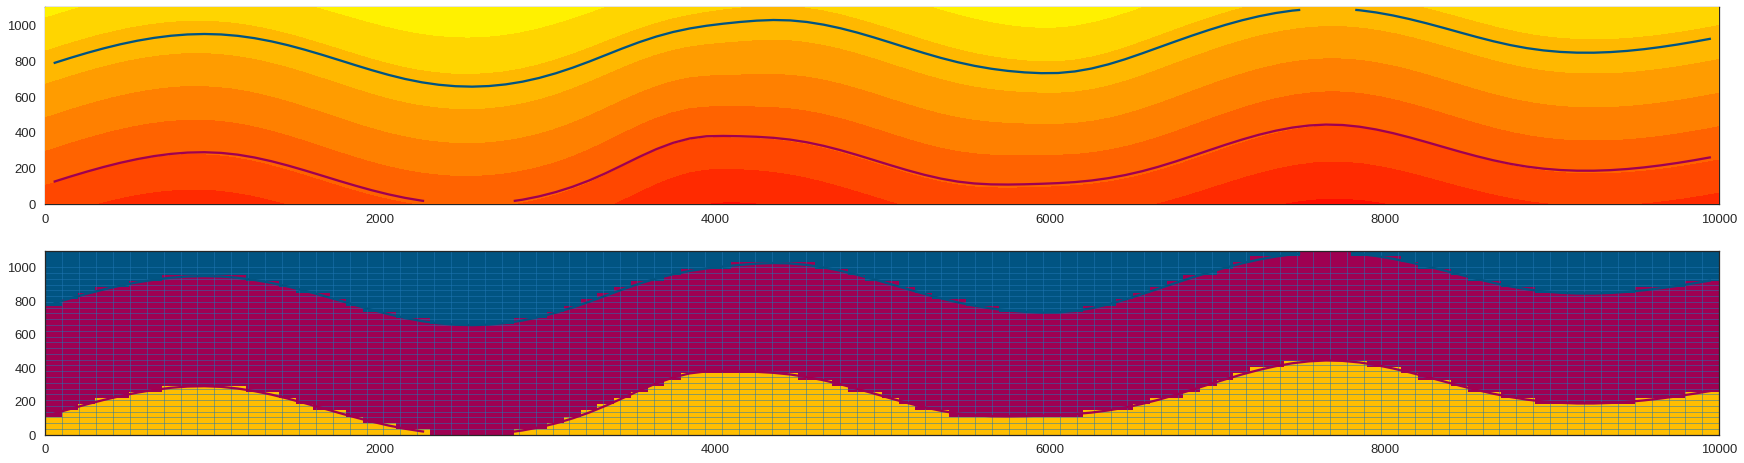

In [7]:
from gempy.plot.visualization_2d_pro import *
fig, ax = plt.subplots(2,1,figsize = (30,8))
ax[0].set_xlim(0,10000)
ax[0].set_ylim(0,1100)
ax[1].set_xlim(0,10000)
ax[1].set_ylim(0,1100)
# ax[2].set_xlim(0,10000)
# ax[2].set_ylim(0,1100)
res = regular_grid_resolution

p = Plot2D(model)
p.plot_scalar_field(ax[0],cell_number=model.regular_grid_resolution[1]//2)
p.plot_contacts(ax[0],cell_number=model.regular_grid_resolution[1]//2)

p.plot_lith(ax[1],cell_number=model.regular_grid_resolution[1]//2)
p.plot_contacts(ax[1],cell_number=model.regular_grid_resolution[1]//2)

v_lines = np.linspace(0,10000,regular_grid_resolution[0])
for v in v_lines:
    ax[1].axvline(x = v,linewidth = 0.5)
h_lines = np.linspace(0,1000,regular_grid_resolution[-1])
for h in h_lines:
    ax[1].axhline(y = h,linewidth = 0.5)

# ax[1].plot(4500,1000,marker = 7,c='r',markersize = 15,label = 'Receiver')
# ax[1].axhline(y = 1000,linewidth = 4, color = 'k',alpha = 0.7)
# ax[1].quiver(center1[:,47,:,0],center1[:,47,:,2],0,-1, -tz[:,47,:],scale=1e-9,width = 0.0003,headwidth = 4,headlength=1,alpha=0.7)
# ax[1].quiver(center1[:,47,:,0]+4500,center1[:,47,:,2]+1000,0,-1, -tz[:,47,:],scale=1e-10,width = 0.003,headwidth = 4,headlength=1,alpha=0.7)
# plt.savefig('/content/drive/MyDrive/YJ/threelayer_scalar_field.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [8]:
# plt.imshow(np.squeeze(-tz[:,48,:].T),origin= 'lower')
# plt.colorbar()

In [9]:
# fig, ax = plt.subplots(figsize = (10,3))
# ax.set_xlim(0,10000)
# ax.set_ylim(0,1100)
# ax = p.plot_lith(ax,cell_number=50)
# plt.gca().set_axis_off()
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig('./three_layer_2d.png',bbox_inches='tight',pad_inches = 0,dpi = 1000)

## Only Centered grid activate here

In [10]:
model.activate_centered_grid()

tz_center = model.tz.numpy()

Compute the gravity

In [11]:
# import copy
# center_res = copy.deepcopy(center_grid_resolution)
# for index, integer in enumerate(center_grid_resolution):
#     center_res[index] += 1

kernel_centers = model.geo_data.grid.centered_grid.kernel_centers
kernel_dxyz_left = model.geo_data.grid.centered_grid.kernel_dxyz_left
kernel_dxyz_right = model.geo_data.grid.centered_grid.kernel_dxyz_right
# a, b, c = kernel_centers, kernel_dxyz_left, kernel_dxyz_right
# heights = np.abs(b[:, 2].reshape(center_res) + c[:, 2].reshape(center_res))
# width_x = (b+c)[:,0].reshape(center_res)
# width_y = (b+c)[:,1].reshape(center_res)

In [12]:
# from PIL import Image
# # img1 = Image.open('./threelayer_scalar_field.png')

# tz = model.tz.numpy()

# centered_grid = model.grid.centered_grid
# slice= None
# resolution=center_res
# slice = 1
# a, b, c = centered_grid.kernel_centers, centered_grid.kernel_dxyz_left, \
#           centered_grid.kernel_dxyz_right

# res = np.array(resolution)
# if slice is None:
#   slice = int(res[1]/2)

# fig = plt.figure(figsize=(20, 5))
# ax = fig.add_subplot(111)

# # ax.imshow(img1, alpha=0.7,extent = (-4500,5500,-1000,0))

# # plot the ground surface at 0
# ax.axhline(y = 0,linewidth = 4, color = 'k',alpha = 0.7)

# for xc in (a[:, 0].reshape(res)[slice, :, slice].ravel() -
#               b[:, 0].reshape(res)[slice, :, slice].ravel()):
#               ax.axvline(x = xc,ymin = 0,ymax=0.9 , linewidth = 2, color = 'b',alpha = 0.2)

# ax.axvline(x = (a+b)[:, 0].reshape(res)[slice, -1, slice].ravel(),ymin = 0,ymax=0.9,linewidth = 2, color = 'b',alpha = 0.2)

# for yc in (a[:, 2].reshape(res)[slice, slice, :].ravel() -
#               b[:, 2].reshape(res)[slice, slice, :].ravel()):
#               ax.axhline(y = yc,xmin = 0.35,xmax = .55, linewidth = 2, color = 'b',alpha = 0.2)


# x  = a[:, 0].reshape(res)[slice, :, :].ravel()
# y  = a[:, 2].reshape(res)[:, slice, :].ravel()


# # ax.scatter(x,y,c ='cornflowerblue',marker = '.', label = 'Centers')

# height = np.abs(b[:, 2].reshape(res)[:, slice,:].ravel() + c[:, 2].reshape(res)[slice, :, :].ravel())
# width = b[:, 0].reshape(res)[slice, :, :].ravel()+c[:, 0].reshape(res)[slice, :, :].ravel()

# ax.quiver(x,
#             y,
#             np.zeros(res[0]*res[2]),
#             tz.reshape(res)[slice, :, :].ravel()/(width*width*height), label='$t_z$', alpha=.3,
#           scale=2e-6
#             )


# ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')
# ax.set_xlim(-4500, 5500)
# ax.set_ylim(-1000, 100)

# # ax.legend(loc  = 'lower right',edgecolor = 'k',borderpad=1,labelspacing=1.5,frameon = True,fancybox=False,shadow=False)

# # plt.savefig('./threelayer_center_2d.png',bbox_inches='tight',pad_inches = 0,dpi = 1000)
# # plt.show()

/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


[0.0, 10000.0, 0.0, 1100.0]
[0.0, 10000.0, 0.0, 1100.0]


ValueError: ignored

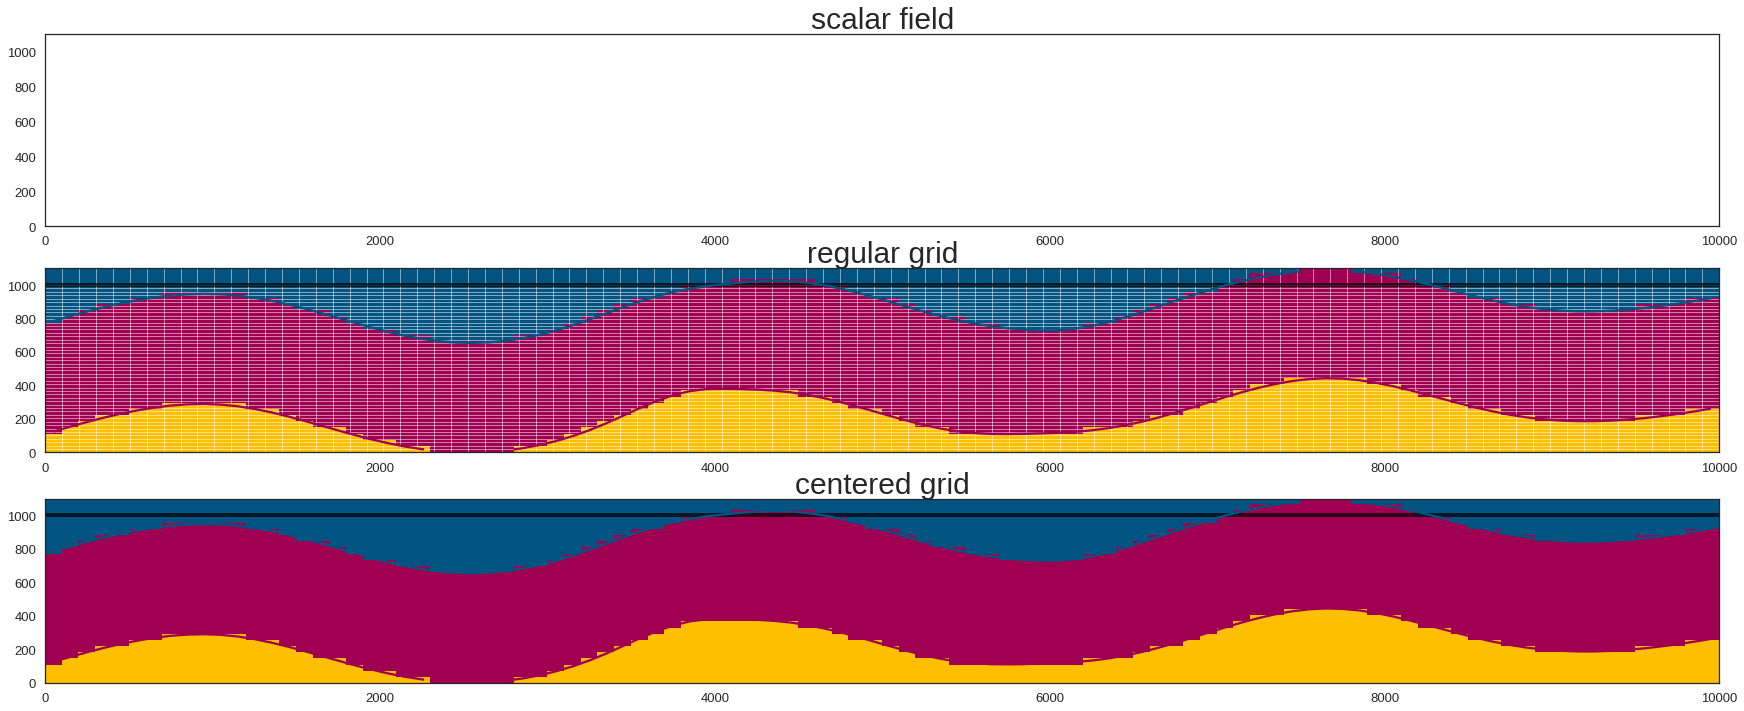

In [13]:
import copy
model.activate_regular_grid()
model.scalar_field(model.surface_points_coord)
from gempy.plot.visualization_2d_pro import *
fig, ax = plt.subplots(3,1,figsize = (30,12))
ax[0].set_xlim(0,10000)
ax[0].set_ylim(0,1100)
ax[1].set_xlim(0,10000)
ax[1].set_ylim(0,1100)

ax[2].set_xlim(0,10000)
ax[2].set_ylim(0,1100)

ax[0].set_title('scalar field',fontsize=30)
ax[1].set_title('regular grid',fontsize=30)
ax[2].set_title('centered grid',fontsize=30)

res = regular_grid_resolution

p = Plot2D(model)
p.plot_lith(ax[2],cell_number=model.regular_grid_resolution[1]//2)
p.plot_contacts(ax[2],cell_number=model.regular_grid_resolution[1]//2)

p.plot_lith(ax[1],cell_number=model.regular_grid_resolution[1]//2)
p.plot_contacts(ax[1],cell_number=model.regular_grid_resolution[1]//2)

v_lines = np.linspace(0,10000,100)
for v in v_lines:
    ax[1].axvline(x = v,linewidth = 0.5,c = 'w')
h_lines = np.linspace(0,1000,50)
for h in h_lines:
    ax[1].axhline(y = h,linewidth = 0.5,c = 'w')

centered_grid = model.grid.centered_grid
a, b, c = centered_grid.kernel_centers, centered_grid.kernel_dxyz_left, \
          centered_grid.kernel_dxyz_right

center_res = copy.deepcopy(center_grid_resolution)

for index, integer in enumerate(center_grid_resolution):
    center_res[index] += 1

resolution=center_res

res = np.array(resolution)

slice = int(res[1]/2)

# plot the ground surface at 0
ax[2].axhline(y = 1000,linewidth = 4, color = 'k',alpha = 0.7)
ax[1].axhline(y = 1000,linewidth = 4, color = 'k',alpha = 0.7)

vlines = (a[:, 0].reshape(res)[slice, :, slice].ravel() - b[:, 0].reshape(res)[slice, :, slice].ravel())

for xc in (vlines):
              ax[2].axvline(x = xc+5000,ymin = 0,ymax=0.9 , linewidth = 2, color = 'w',alpha = 0.2)

## the right most vline
ax[2].axvline(x = (a+b)[:, 0].reshape(res)[slice, -1, slice].ravel()+5000,ymin = 0,ymax=0.9,linewidth = 2, color = 'w',alpha = 0.2)

left_most = vlines[0]

left_most_vline  = ((5000 + left_most)/10000)
right_most_vline  = ((5000 - left_most)/10000)

for yc in (a[:, 2].reshape(res)[slice, slice, :].ravel() -
              b[:, 2].reshape(res)[slice, slice, :].ravel()):
              ax[2].axhline(y = yc+1000,xmin = left_most_vline,xmax = right_most_vline, linewidth = 2, color = 'w',alpha = 0.2)


x  = a[:, 0].reshape(res)[slice, :, :].ravel()
y  = a[:, 2].reshape(res)[:, slice, :].ravel()


# ax[2].scatter(x,y,c ='cornflowerblue',marker = '.', label = 'Centers')

height = np.abs(b[:, 2].reshape(res)[:, slice,:].ravel() + c[:, 2].reshape(res)[slice, :, :].ravel())+1000
width = b[:, 0].reshape(res)[slice, :, :].ravel()+c[:, 0].reshape(res)[slice, :, :].ravel()+5000

# ax[2].quiver(x,
#             y,
#             np.zeros(res[0]*res[2]),
#             tz.reshape(res)[slice, :, :].ravel()/(width*width*height), label='$t_z$', alpha=.3,
#           scale=2e-6
#             )


ax[2].plot(5000,1000,marker = 7,c='r',markersize = 15,label = 'Receiver')


p.plot_scalar_field(ax[0],cell_number=model.regular_grid_resolution[1]//2)
p.plot_contacts(ax[0],cell_number=model.regular_grid_resolution[1]//2)
# ax[1].plot(4500,1000,marker = 7,c='r',markersize = 15,label = 'Receiver')
# ax[1].axhline(y = 1000,linewidth = 4, color = 'k',alpha = 0.7)
# ax[1].quiver(center1[:,47,:,0],center1[:,47,:,2],0,-1, -tz[:,47,:],scale=1e-9,width = 0.0003,headwidth = 4,headlength=1,alpha=0.7)
# ax[1].quiver(center1[:,47,:,0]+4500,center1[:,47,:,2]+1000,0,-1, -tz[:,47,:],scale=1e-10,width = 0.003,headwidth = 4,headlength=1,alpha=0.7)
# plt.savefig('/content/drive/MyDrive/YJ/threelayer_scalar_field.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
(a[:, 0].reshape(res)[slice, :, slice].ravel() - b[:, 0].reshape(res)[slice, :, slice].ravel())[0]

The width of the cells grows exponentially 

In [ ]:
print(round(getsizeof(model.tz.numpy())/1024/1024,2),'MB')

0.3 MB


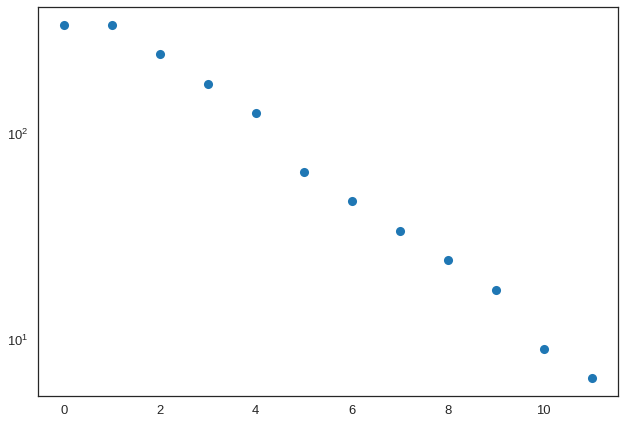

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot((kernel_dxyz_left[:int((res[0]/2)*res[2]):50,0]*2)[:-1],'o')

ax.set_yscale('log')

In [ ]:
a = (kernel_dxyz_left[:int((res[0]/2)*res[2]):50,0]*2)[::-1]
np.cumsum(a)

array([   4.67394593,   11.16837275,   20.19234954,   37.61492105,
         61.82350566,   95.4612249 ,  142.20068422,  207.14495237,
        332.53270337,  506.75841844,  748.84426453, 1085.22145693,
       1421.59864933])

In the range of 500m,  the avarage cell width is 30m

In [ ]:
avg_cell_centered = np.mean(a[:17])
print(avg_cell_centered)

109.3537422562014


To reach such a cell width in a centered regular grid, requires 100 by 100 resolution, centered grid only about 40% portion of the resolution on each dimension, which saves in total about 90% cells

In [ ]:
#number of centered regular grid needed
6000/avg_cell_centered

54.86780677283811

In [ ]:
#number of all regular grid needed
10000/avg_cell_centered

91.44634462139685

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# tz = model.tz.numpy()
# centers_centergrid = model.geo_data.grid.centered_grid.kernel_centers
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2], '.', alpha=.2,s=10)

# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=100)

# ax.quiver(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2],0,0, tz, length=5000,arrow_length_ratio=0.3)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

If we normalize the arrows by the volumn of the cell

In [ ]:

# from mpl_toolkits.mplot3d import Axes3D
# centers_centergrid = model.geo_data.grid.centered_grid.kernel_centers
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2], '.', alpha=.2,s=10)

# # center position
# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=30)

# new_tz = (tz.reshape(center_res)/(width_x*width_y*heights)).ravel()
# ax.quiver(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2],0,0, new_tz, length=1e8,arrow_length_ratio=0.05,alpha = 0.3,normalize=False)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

In [ ]:
#normalized Tz
# plt.plot(new_tz)

In [ ]:
model.activate_centered_grid()

/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),


<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-97.26964277])>

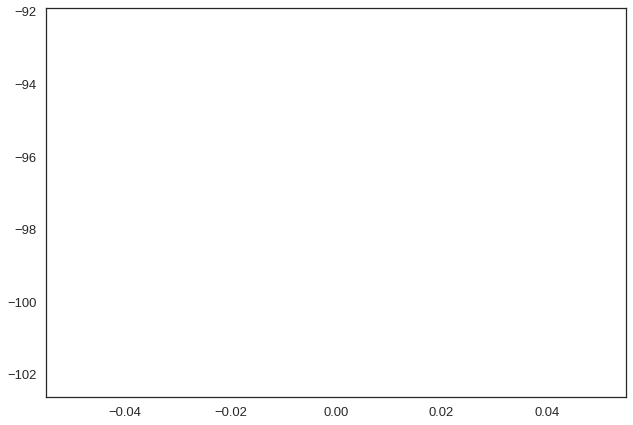

In [ ]:
grav_centered = model.calculate_grav(model.surface_points_coord,model.values_properties)
plt.plot(grav_centered)
grav_centered

In [ ]:
# surface_coord = model.surface_points_coord
# values_properties = model.values_properties
# model.TFG = TFGraph(model.dip_angles, model.azimuth,
#     model.polarity, model.fault_drift,
#     model.grid_tensor, model.values_properties, model.len_rest_form, model.Range,
#     model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
#     model.rescale_factor,dtype = model.tfdtype)
# Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)
# scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)


In [ ]:
# slope = 1000
# scalar_field_iter = tf.pad(tf.expand_dims(
#     scalar_field_at_surface_points, 0), [[0, 0], [1, 1]])[0]

# n_surface_op_float_sigmoid_mask = tf.repeat(
#     values_properties, 2, axis=1)
# n_surface_op_float_sigmoid = tf.pad(
#     n_surface_op_float_sigmoid_mask[:, 1:-1], [[0, 0], [1, 1]])
# drift = tf.pad(
#     n_surface_op_float_sigmoid_mask[:, 0:-1], [[0, 0], [0, 1]])
# formations_block = tf.zeros([1, tf.shape(Z_x)[0]], dtype=model.TFG.dtype)

# # need to check if Hessian works for this, otherwise vectorize
# # code for vectorization
# # tf.concat([tf.expand_dims(tf.range(scalar_field_iter.shape[1]-1),1),
# # tf.expand_dims(tf.range(scalar_field_iter.shape[1]-1)+1,1)],-1)

# # for i in range(model.TFG.number_of_series+2):
# for i in range(3):
# ## tensorflow autograph trick, only with this loop set to concret shape, second order derivative can work properly in graph mode
#     tf.autograph.experimental.set_loop_options(
#         shape_invariants=[(formations_block, tf.TensorShape([None, Z_x.shape[0]]))])

#     formations_block = formations_block + \
#         model.TFG.compare(scalar_field_iter[i], scalar_field_iter[i + 1],
#                         2 * i, Z_x, slope, n_surface_op_float_sigmoid, drift)
#     plt.plot(model.TFG.compare(scalar_field_iter[i], scalar_field_iter[i + 1],
#                         2 * i, Z_x, slope, n_surface_op_float_sigmoid, drift)[1][:50])

# # if model.TFG.gradient is True:
# ReLU_up = - 0.01 * tf.nn.relu(Z_x - scalar_field_iter[1])
# ReLU_down = 0.01 * tf.nn.relu( scalar_field_iter[-2]-Z_x)

# formations_block += ReLU_down + ReLU_up

In [ ]:
#Plot relu 
# plt.plot((ReLU_down + ReLU_up)[:30])

In [ ]:
# model.geo_data.surfaces

In [ ]:
# plt.plot(Z_x[:50],c='k')
# plt.hlines(scalar_field_iter[1],0,50,colors='r',label='layer1')
# plt.hlines(scalar_field_iter[2],0,50,colors='b',label='layer2')
# plt.title('scalar field')
# plt.legend(loc = 'lower right')

## Gravity on Regular Grid

Let's try use all regular grids, because the regular grids are not centered abour a receiver, individual tz matrix are required for each receiver.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce

model.activate_regular_grid()

/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),


In [ ]:
def calculate_grav_regulargrid(surface_coord,values_properties,radiaus =1000):
  model.scalar_field(model.surface_points_coord)
  g = GravityPreprocessingRegAll(model,model.grid.regular_grid)
  tz = g.set_tz_kernel()

  regular_res = model.regular_grid_resolution
  size = reduce((lambda x, y: x * y), regular_res)

  values_properties = values_properties
  model.TFG = TFGraph(model.dip_angles, model.azimuth,
          model.polarity, model.fault_drift,
          model.grid_tensor, model.values_properties, model.len_rest_form, model.Range,
          model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
          model.rescale_factor,dtype = model.tfdtype)

  model.TFG.sig_slope = 1000
  Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)

  scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
  # formations_block = model.TFG.export_formation_block(
  #     Z_x, scalar_field_at_surface_points, model.values_properties)
  formations_block = model.TFG.export_formation_block(
      Z_x, scalar_field_at_surface_points, values_properties)

  densities = formations_block[1][:size]

  ## cell index of the receivers
  dx,dy,dz = g.model.grid.regular_grid.get_dx_dy_dz()
  center_index_x = g.new_xy_ravel[0]//dx
  center_index_y = g.new_xy_ravel[1]//dy
  radiaus = radiaus

  radiaus_cell = int(radiaus//dx)

  def Slice(t):
    sliced_tz = np.empty((reduce(operator.mul, [radiaus_cell*2,radiaus_cell*2,model.regular_grid_resolution[-1]], 1),0), float)
    for i in range(g.num_receivers):
      c_x = int(center_index_x[i])
      c_y = int(center_index_y[i])

      sliced_tz = np.append(sliced_tz,t[:,:].reshape(model.regular_grid_resolution+[g.num_receivers])[c_x-radiaus_cell:c_x+radiaus_cell,c_y-radiaus_cell:c_y+radiaus_cell,:,i].reshape(-1,1),axis = 1)
    return sliced_tz

  sliced_tz = Slice(tz)

  densities_tile = tf.repeat(tf.reshape(densities,[-1,1]),[n_devices],axis=1).numpy()
  sliced_densities = Slice(densities_tile)

  grav_regular = tf.reduce_sum(sliced_densities*sliced_tz, axis=0)
  
  return grav_regular

In [ ]:
surface_coord = model.surface_points_coord
grav_regular = calculate_grav_regulargrid(surface_coord,model.values_properties)

NameError: ignored

In [ ]:

# model.scalar_field(model.surface_points_coord)
# g = GravityPreprocessingRegAll(model,model.grid.regular_grid)
# tz = g.set_tz_kernel()

# regular_res = model.regular_grid_resolution
# size = reduce((lambda x, y: x * y), regular_res)

Memory usage of Tz

In [ ]:
# print(round(getsizeof(tz/n_devices)/1024/1024,2),'MB')

In [ ]:
# surface_coord = model.surface_points_coord
# values_properties = model.values_properties
# model.TFG = TFGraph(model.dip_angles, model.azimuth,
#         model.polarity, model.fault_drift,
#         model.grid_tensor, model.values_properties, model.len_rest_form, model.Range,
#         model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
#         model.rescale_factor,dtype = model.tfdtype)

# model.TFG.sig_slope = 1000
# Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)

# scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
# # formations_block = model.TFG.export_formation_block(
# #     Z_x, scalar_field_at_surface_points, model.values_properties)
# formations_block = model.TFG.export_formation_block(
#     Z_x, scalar_field_at_surface_points, values_properties)

# densities = formations_block[1][:size]


In [ ]:
# kernel_centers = np.repeat(model.grid.regular_grid.values[:,:,np.newaxis],n_devices,axis=2)-model.xy_ravel.T

In [ ]:
# # 3D plotting
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# center1 = kernel_centers[:,:,0]

# # ax.scatter(center1[:size, 0], center1[:size, 1], center1[:size, 2], '.', alpha=.2,s=10)

# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=30)

# # ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2], -center1[:size, 0], -center1[:size, 1], -center1[:size, 2], length=0.1,alpha=0.01)

# ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2],0,0, tz[:,0], length=1e4,alpha=0.1)
# ax.view_init(elev=60, azim=10)

In [ ]:
# plt.imshow(tz[:,0].reshape(model.regular_grid_resolution)[:,50,:].T,origin='lower')
# plt.colorbar()

In [ ]:
# ## cell index of the receivers
# dx,dy,dz = g.model.grid.regular_grid.get_dx_dy_dz()
# center_index_x = g.new_xy_ravel[0]//dx
# center_index_y = g.new_xy_ravel[1]//dy
# radiaus = 1000

# radiaus_cell = int(radiaus//dx)

# def Slice(t):
#   sliced_tz = np.empty((reduce(operator.mul, [radiaus_cell*2,radiaus_cell*2,model.regular_grid_resolution[-1]], 1),0), float)
#   for i in range(g.num_receivers):
#     c_x = int(center_index_x[i])
#     c_y = int(center_index_y[i])

#     sliced_tz = np.append(sliced_tz,t[:,:].reshape(model.regular_grid_resolution+[g.num_receivers])[c_x-radiaus_cell:c_x+radiaus_cell,c_y-radiaus_cell:c_y+radiaus_cell,:,i].reshape(-1,1),axis = 1)
#   return sliced_tz

# sliced_tz = Slice(tz)

In [ ]:
# densities_tile = tf.repeat(tf.reshape(densities,[-1,1]),[n_devices],axis=1).numpy()
# sliced_densities = Slice(densities_tile)

In [ ]:
# grav_regular = tf.reduce_sum(sliced_densities*sliced_tz, axis=0)

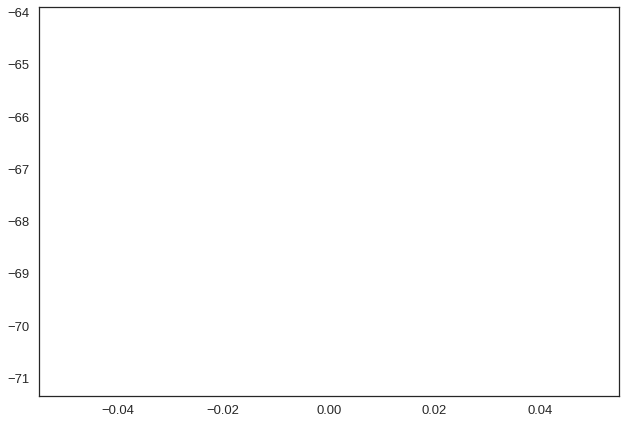

In [ ]:
plt.plot(grav_regular)

mean square error: 0.20254484510927095


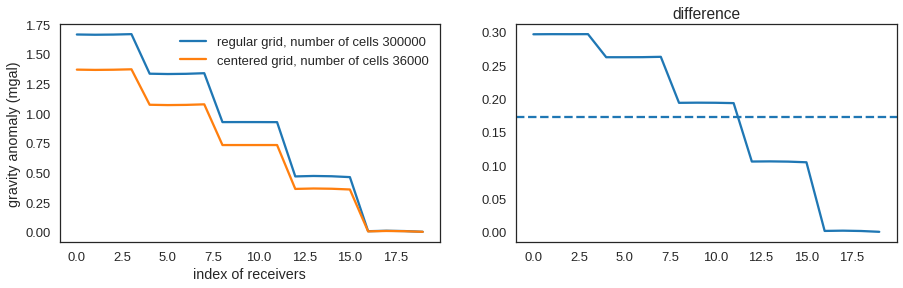

In [ ]:
# grav_regular_norm = grav_regular - np.min(grav_regular)
# grav_centered_norm = grav_centered - np.min(grav_centered)
# fig,ax = plt.subplots(1,2, figsize = (15,4))
# ax[0].plot(grav_regular_norm, label = 'regular grid, number of cells '+str(np.prod(regular_grid_resolution)))
# ax[0].plot(grav_centered_norm, label = 'centered grid, number of cells ' +str(np.prod(center_grid_resolution)))
# # plt.plot(gravity_center_reg_norm, label = 'centered regular grid')
# ax[0].legend()
# ax[0].set_ylabel('gravity anomaly (mgal)')
# ax[0].set_xlabel('index of receivers')

# ax[1].set_title('difference')
# diff = grav_regular_norm-grav_centered_norm
# ax[1].plot(diff)
# ax[1].axhline(y = np.average(diff),linestyle = '--')
# print('mean square error:', np.sqrt(np.average(diff**2)))

# # plt.savefig('/content/drive/MyDrive/YJ/gravity.png',bbox_inches = 'tight')

# Resolution check

In [ ]:
grav_regular_list = []
grav_center_list = []
res_list = []
path = '/content/drive/MyDrive/YJ/GP_old/notebooks'
orientation_path = "/data/input_data/George_models/modely_orientations.csv"
surface_path = '/data/input_data/George_models/'+"modely"+'_surface_points.csv'
for i in range(100,300,20):
# for i in [100]:
  center_grid_resolution = [30, 30, 40]
  regular_grid_resolution =[i, i, 30]

  model = ModelThree(path,surface_path,orientation_path,receivers = receivers,center_grid_resolution = center_grid_resolution,regular_grid_resolution =regular_grid_resolution,dtype = 'float64')
  model.activate_regular_grid()
  grav_regular = calculate_grav_regulargrid(model.surface_points_coord,model.values_properties)

  model.activate_centered_grid()
  grav_centered = model.calculate_grav(model.surface_points_coord,model.values_properties)

  grav_regular_list.append(grav_regular)
  grav_center_list.append(grav_centered)

  # diff = grav_regular_norm-grav_centered_norm

  # calculate the mean square error
  # diff_list.append(np.sqrt(np.average(np.square(diff))))
  res_list.append(str(i*i*30/10000))
print(res_list)

Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


['30.0', '43.2', '58.8', '76.8', '97.2', '120.0', '145.2', '172.8', '202.8', '235.2']


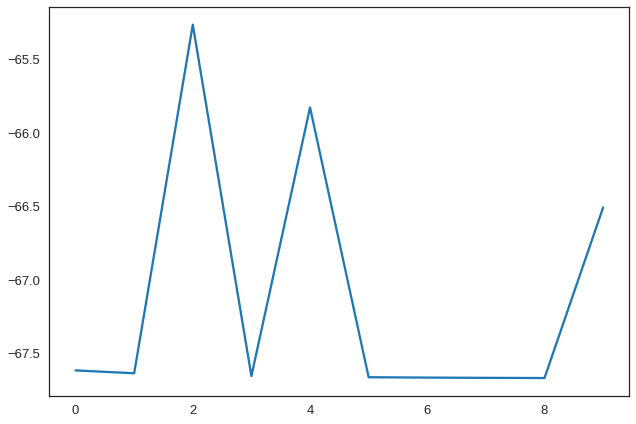

In [ ]:
plt.plot(grav_regular_list)

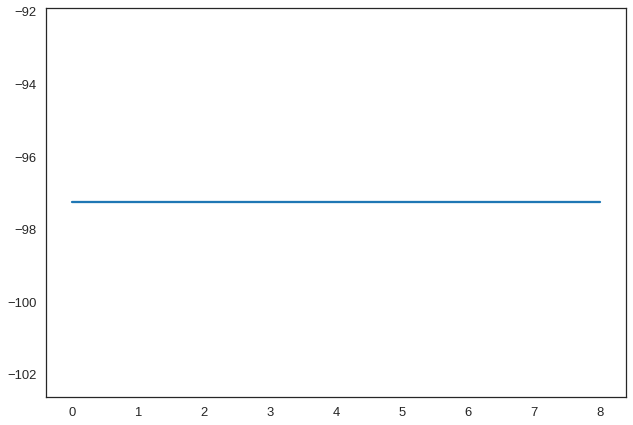

In [ ]:
plt.plot(grav_center_list)

In [ ]:
# diff_list = []
# res_list = []
# path = '/content/drive/MyDrive/YJ/GP_old/notebooks'
# orientation_path = "/data/input_data/George_models/modely_orientations.csv"
# surface_path = '/data/input_data/George_models/'+"modely"+'_surface_points.csv'
# for i in range(20,200,20):
# # for i in [100]:
#   center_grid_resolution = [30, 30, 40]
#   regular_grid_resolution =[i, i, 30]

#   model = ModelThree(path,surface_path,orientation_path,receivers = receivers,center_grid_resolution = center_grid_resolution,regular_grid_resolution =regular_grid_resolution,dtype = 'float64')
#   model.activate_regular_grid()
#   grav_regular = calculate_grav_regulargrid(model.surface_points_coord,model.values_properties)

#   model.activate_centered_grid()
#   grav_centered = model.calculate_grav(model.surface_points_coord,model.values_properties)

#   grav_regular_norm = grav_regular - np.min(grav_regular)
#   grav_centered_norm = grav_centered - np.min(grav_centered)

#   diff = grav_regular_norm-grav_centered_norm

#   # calculate the mean square error
#   diff_list.append(np.sqrt(np.average(np.square(diff))))
#   res_list.append(str(i*i*30/10000))
# print(res_list)

Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/content/drive/My Drive/YJ/GP_old/gempy/assets/geophysics.py:72: RuntimeWarning: divide by zero encountered in true_divide
  z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
/content/drive/My Drive/YJ/GP_old/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


['1.2', '4.8', '10.8', '19.2', '30.0', '43.2', '58.8', '76.8', '97.2']


In [ ]:
diff_list

[0.06322479618172712,
 0.0473303079309257,
 0.043547916375262195,
 0.041933419039478434,
 0.04102441428033856,
 0.040451547997776185,
 0.058555910730539576,
 0.03977635308225068,
 0.05348646079090995]

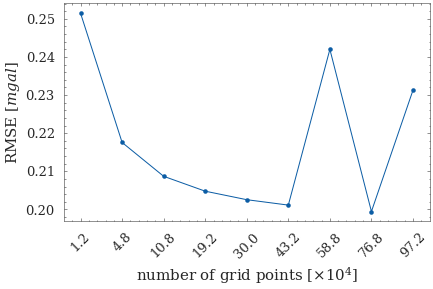

In [ ]:
with plt.style.context(['science', 'no-latex']):
    fig, ax = plt.subplots(constrained_layout=True,figsize=(6,4))
    ax.plot(diff_list[0:],'.-')
    ax.set_ylabel(r'RMSE [$mgal$]',fontsize=15)
    ax.set_xlabel(r'number of grid points [$\times 10^4$]',fontsize=15)
    ax.set_xticks(np.linspace(0,8,9,dtype=int))
    ax.set_xticklabels(res_list, minor=False, rotation=45)
    # plt.savefig('/content/drive/MyDrive/YJ/Fig/grid_resolutoin.png',dpi=300, transparent=False, bbox_inches='tight')
    plt.show()

# Centered regular grid

In [ ]:
from gempy.core.grid_modules.grid_types import CenteredGrid

In [ ]:
class CenteredRegGrid(CenteredGrid):
    """
    linear spaced centered grid.
    """
    @staticmethod
    def create_irregular_grid_kernel(resolution, radius):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """

        if radius is not list or radius is not np.ndarray:
            radius = np.repeat(radius, 3)

        g_ = []
        g_2 = [] # contains exp coord, left right xy, top and bottom
        d_ = []
        dz = radius[2]/resolution[2]
        for xyz in [0, 1, 2]:
            if xyz == 2: # --> z
                # Make the grid only negative for the z axis
                g_.append(np.linspace(0, 1, int(resolution[xyz]),endpoint=False))
                g_2.append(
                    ((g_[xyz]+0.005)* - radius[xyz] - dz/2))
                
                d_.append(np.diff(np.pad(g_2[xyz], 1, 'reflect', reflect_type='odd')))
            else:
                g_.append(np.linspace(0, 1, num = int(resolution[xyz] / 2+1)))
                g_2.append(
                    np.concatenate((-g_[xyz][::-1], g_[xyz][1:])) * radius[xyz])
                d_.append(np.diff(np.pad(g_2[xyz], 1, 'reflect', reflect_type='odd')))
        
        g = np.meshgrid(*g_2)
        d_left = np.meshgrid(d_[0][:-1] / 2, d_[1][:-1] / 2, d_[2][:-1]/2)
        d_right = np.meshgrid(d_[0][1:] / 2, d_[1][1:] / 2, d_[2][1:]/2)
        kernel_g = np.vstack(tuple(map(np.ravel, g))).T.astype("float64")
        kernel_d_left = np.vstack(tuple(map(np.ravel, d_left))).T.astype("float64")
        kernel_d_right = np.vstack(tuple(map(np.ravel, d_right))).T.astype("float64")

        return kernel_g, kernel_d_left, kernel_d_right


In [ ]:
res = [10,8,6]
centerReg = CenteredRegGrid(model.xy_ravel,radius=1000,resolution=res)
size = reduce((lambda x, y: x * y), res)

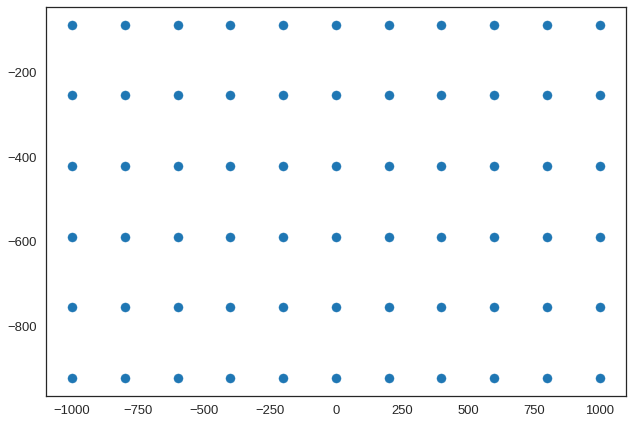

In [ ]:
kernel_g, kernel_d_left, kernel_d_right = centerReg.create_irregular_grid_kernel(resolution = res,radius=1000)
Slice = 5
res_ =copy.deepcopy(res)

# plotting the centers

# x = kernel_g[:,1].reshape([9,11,6])[:,Slice,:]
# y = kernel_g[:,2].reshape([9,11,6])[:,Slice,:]
x = kernel_g[:,0].reshape([9,11,6])[Slice,:,:]
y = kernel_g[:,2].reshape([9,11,6])[Slice,:,:]
plt.scatter(x,y)

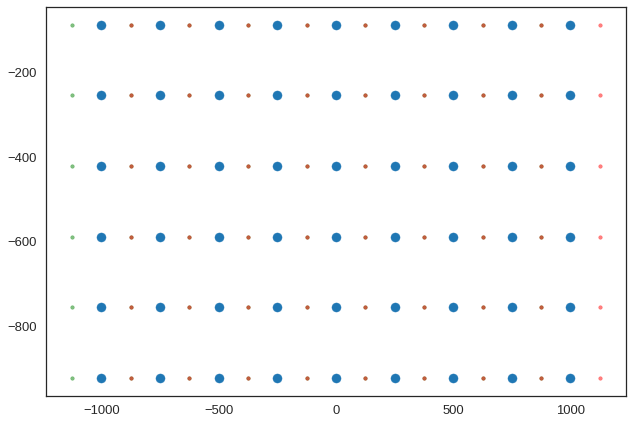

In [ ]:
def plot_centered_kernel(res,radius,centerkernel,direction = 'y',n_section = 5):
  res_ =copy.deepcopy(res)
  if direction == 'y': i = 0 
  else: i = 1
  
  if isinstance(centerkernel,CenteredRegGrid):
    kernel_g, kernel_d_left, kernel_d_right = centerReg.create_irregular_grid_kernel(resolution = res,radius=1000)
    Slice = n_section
    # Trick just for plotting
    # the resolution is transposed in meshgrid
    res_[0]+=1
    res_[1]+=1
    res_[0],res_[1] =res_[1], res_[0]
    # plotting the centers
    if i == 0: # y direction        
      plt.scatter(kernel_g[:,i].reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:])
      plt.scatter((kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],'r')
    if i == 1: # x direction
      plt.scatter(kernel_g[:,i].reshape(res_)[:,Slice,:],kernel_g[:,2].reshape(res_)[:,Slice,:])
      left_x = (kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[:,Slice,:].flatten()
      right_x = (kernel_g[:,i]+kernel_d_right[:,i]).reshape(res_)[:,Slice,:].flatten()
      plt.scatter(left_x,kernel_g[:,2].reshape(res_)[:,Slice,:].flatten(),s  =13, c = 'g',alpha=0.5)
      plt.scatter(right_x,kernel_g[:,2].reshape(res_)[:,Slice,:].flatten(),s = 13, c = 'r',alpha=0.5)

    #plotting the corners
    # plt.scatter(kernel_d_left[:,0].reshape(res_)[:,Slice,:],kernel_d_left[:,2].reshape(res_)[:,Slice,:])
plot_centered_kernel(res,1000,centerReg,'x')

In [ ]:
kernel_centers = centerReg.kernel_centers
kernel_dxyz_left = centerReg.kernel_dxyz_left
kernel_dxyz_right = centerReg.kernel_dxyz_right

In [ ]:
g_center_regulargrid = GravityPreprocessing(centerReg)
tz_center_regulargrid = g_center_regulargrid.set_tz_kernel()

In [ ]:
model.grid_tensor

<tf.Tensor: shape=(39401, 3), dtype=float64, numpy=
array([[0.4401    , 0.4401    , 0.52359466],
       [0.4401    , 0.4401    , 0.52287466],
       [0.4401    , 0.4401    , 0.52278441],
       ...,
       [0.5601    , 0.5601    , 0.46673969],
       [0.5601    , 0.5601    , 0.45961374],
       [0.5601    , 0.5601    , 0.45159466]])>

In [ ]:
# calculate gravity kernel for centered regular grid
def calculate_grav(surface_coord, values_properties):

    ## set the dips position the same as surface point position

    model.TFG = TFGraph(model.dip_angles, model.azimuth,
            model.polarity, model.fault_drift,
            model.grid_tensor, model.values_properties, model.len_rest_form, model.Range,
            model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
            model.rescale_factor,dtype = model.tfdtype)
    Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)

    scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
    # formations_block = model.TFG.export_formation_block(
    #     Z_x, scalar_field_at_surface_points, model.values_properties)
    formations_block = model.TFG.export_formation_block(
        Z_x, scalar_field_at_surface_points, values_properties)

    # densities = formations_block[1][model.lg_0:model.lg_1]
    densities = formations_block[1][model.lg_0:model.lg_1]

    gravity = model.TFG.compute_forward_gravity(model.tz, model.lg_0, model.lg_1, densities)

    return gravity

In [ ]:
# activate the customized grid
def activate_customized_grid(model,centerReg):
  model.geo_data.grid.custom_grid=centerReg

In [ ]:
def plot_grid_2d(centerGrid,ax):
  kernel_centers = centerGrid.kernel_centers
  kernel_dxyz_left = centerGrid.kernel_dxyz_left
  kernel_dxyz_right = centerGrid.kernel_dxyz_right
  a,b,c = kernel_centers,kernel_dxyz_left,kernel_dxyz_right
  slice = 5
  vlines = (a[:, 0].reshape(res)[slice, :, slice].ravel() - b[:, 0].reshape(res)[slice, :, slice].ravel())
  for xc in (vlines):
              ax.axvline(x = xc+5000,ymin = 0,ymax=0.9 , linewidth = 2, color = 'k',alpha = 0.2)
  left_most = vlines[0]

  left_most_vline  = (((5000 + left_most)-4000)/2000)
  right_most_vline  = (((5000 - left_most)-4000)/2000)

ValueError: ignored

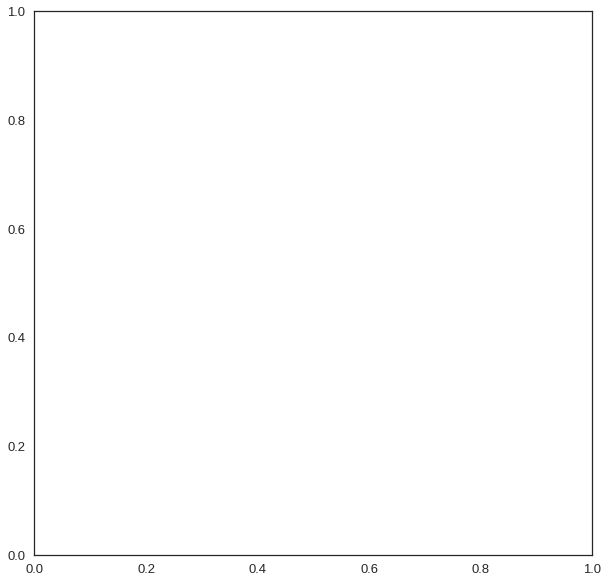

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

a,b,c = kernel_centers,kernel_dxyz_left,kernel_dxyz_right
slice = 3
# plot the centers
centers_x = a[:, 0].reshape(res)
centers_z = a[:, 2].reshape(res)
ax.scatter(centers_x[:,slice,:].ravel(),centers_z[:,slice,:].ravel())

(4000.0, 6000.0)

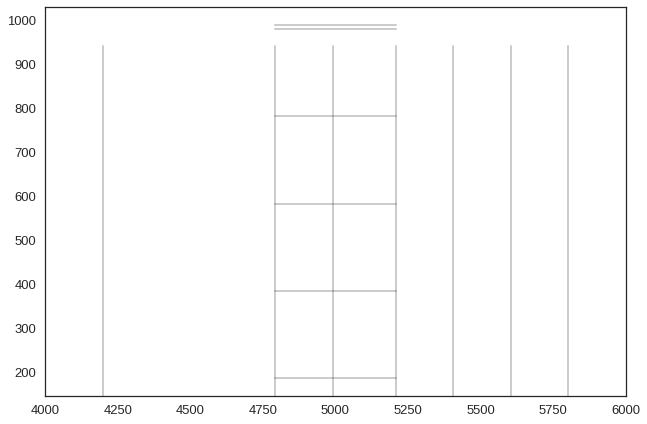

In [ ]:

fig,ax = plt.subplots(1,1)

vlines = (a[:, 0].reshape(res)[slice, :, slice].ravel() - b[:, 0].reshape(res)[slice, :, slice].ravel())

for xc in (vlines):
              ax.axvline(x = xc+5000,ymin = 0,ymax=0.9 , linewidth = 2, color = 'k',alpha = 0.2)


left_most = vlines[0]

left_most_vline  = (((5000 + left_most)-4000)/2000)
right_most_vline  = (((5000 - left_most)-4000)/2000)

for yc in (a[:, 2].reshape(res)[slice, slice, :].ravel() -
              b[:, 2].reshape(res)[slice, slice, :].ravel()):
              ax.axhline(y = yc+1000,xmin = left_most_vline,xmax = right_most_vline, linewidth = 2, color = 'k',alpha = 0.2)


x  = a[:, 0].reshape(res)[slice, :, :].ravel()
y  = a[:, 2].reshape(res)[:, slice, :].ravel()
ax.set_xlim(4000,6000)
xlim = ax.get_xlim()
xlim


In [ ]:
center_z = a[:, 2].reshape(res)[:, slice, :]

In [ ]:
center_z.shape

(10, 10)

In [ ]:
plt.scatter(center_z)

# Regular grid in range

In [ ]:
from gempy.core.grid_modules.grid_types import CenteredGrid

In [ ]:
class CenteredRegGrid(CenteredGrid):
    """
    linear spaced centered grid.
    """
    @staticmethod
    def create_irregular_grid_kernel(resolution, radius):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """

        if radius is not list or radius is not np.ndarray:
            radius = np.repeat(radius, 3)

        g_ = []
        g_2 = [] # contains exp coord, left right xy, top and bottom
        d_ = []
        for xyz in [0, 1, 2]:

            if xyz == 2:
                # Make the grid only negative for the z axis

                g_.append(np.linspace(0.0001, 1, int(resolution[xyz])))
                g_2.append(
                    (np.concatenate(([0], g_[xyz])) + 0.0001) * - radius[xyz])
            else:
                g_.append(np.linspace(0.0001, 1, int(resolution[xyz] / 2)+1))
                g_2.append(
                    np.concatenate((-g_[xyz][::-1], g_[xyz][1:])) * radius[xyz])
        
        #my modification below, change the left/right boundary to grow exponentally instead of the center point
        
        x_center = (g_2[0][:-1]+g_2[0][1:])/2 
        y_center = (g_2[1][:-1]+g_2[1][1:])/2
        z_center = (g_2[-1][:-1]+g_2[-1][1:])/2
        g = np.meshgrid(x_center,y_center,z_center)
        
        d_left_x = np.abs(g_2[0][:-1] - x_center)
        d_left_y = np.abs(g_2[1][:-1] - y_center)
        d_right_x = np.abs(g_2[0][1:] - x_center)
        d_right_y = np.abs(g_2[1][1:] - y_center)
        d_z = z_center - g_2[-1][:-1]
        
        d_left = np.meshgrid(d_left_x,d_left_y,d_z)
        d_right = np.meshgrid(d_right_x,d_right_y,d_z)
    
        kernel_g = np.vstack(tuple(map(np.ravel, g))).T.astype("float64")
        kernel_d_left = np.vstack(tuple(map(np.ravel, d_left))).T.astype("float64")
        kernel_d_right = np.vstack(tuple(map(np.ravel, d_right))).T.astype("float64")

        print('yes')
        return kernel_g, kernel_d_left, kernel_d_right


In [ ]:
res = [70,70,50]
centerReg = CenteredRegGrid(model.xy_ravel,radius=1000,resolution=res)
size = reduce((lambda x, y: x * y), res)

In [ ]:
tz = centerReg.set_tz_kernel()

In [ ]:
plt.plot(tz)

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# centers_centergrid = centerReg.kernel_centers
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2], '.', alpha=.2,s=10)

# # ax.scatter(np.array([[0, 0, 0]])[:, 0],
# #            np.array([[0, 0, 0]])[:, 1],
# #            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=100)

# ax.quiver(centers_centergrid[:size, 0], centers_centergrid[:size, 1], centers_centergrid[:size, 2],0,0, tz, length=1e11,alpha=0.3)
# ax.view_init(elev=30., azim=45)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

In [ ]:

grid_values = centerReg.kernel_centers

s_gr_x = grid_values[:, 0]
s_gr_y = grid_values[:, 1]
s_gr_z = grid_values[:, 2]

# getting the coordinates of the corners of the voxel...
x_cor = np.stack((s_gr_x - centerReg.kernel_dxyz_left[:, 0],
                    s_gr_x + centerReg.kernel_dxyz_right[:, 0]), axis=1)
y_cor = np.stack((s_gr_y - centerReg.kernel_dxyz_left[:, 1],
                    s_gr_y + centerReg.kernel_dxyz_right[:, 1]), axis=1)
z_cor = np.stack((s_gr_z - centerReg.kernel_dxyz_left[:, 2],
                    s_gr_z + centerReg.kernel_dxyz_right[:, 2]), axis=1)

# ...and prepare them for a vectorial op
x_matrix = np.repeat(x_cor, 4, axis=1)
y_matrix = np.tile(np.repeat(y_cor, 2, axis=1), (1, 2))
z_matrix = np.tile(z_cor, (1, 4))

s_r = np.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

# This is the vector that determines the sign of the corner of the voxel
mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])

G = 6.674e-3

centerReg.tz = (
    np.sum(- 1 *
            G *
            mu * (
                    x_matrix * np.log(y_matrix + s_r) +
                    y_matrix * np.log(x_matrix + s_r) -
                    z_matrix * np.arctan(
                x_matrix * y_matrix / (z_matrix * s_r))),
            axis=1))


In [ ]:
from PIL import Image
# img1 = Image.open('./three_layer_2d.png')

tz = centerReg.set_tz_kernel()

# centerReg = model.grid.centered_grid
slice= None
resolution=res
slice = 1
a, b, c = centerReg.kernel_centers, centerReg.kernel_dxyz_left, \
          centerReg.kernel_dxyz_right

res = np.array(resolution)
if slice is None:
  slice = int(res[1]/2)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

# ax.imshow(img1, alpha=0.7,extent = (-4500,5500,-1000,0))

# plot the ground surface at 0
ax.axhline(y = 0,linewidth = 4, color = 'k',alpha = 0.7)

for xc in (a[:, 0].reshape(res)[slice, :, slice].ravel() -
              b[:, 0].reshape(res)[slice, :, slice].ravel()):
              ax.axvline(x = xc,ymin = 0,ymax=0.9 , linewidth = 2, color = 'b',alpha = 0.2)

ax.axvline(x = (a+b)[:, 0].reshape(res)[slice, -1, slice].ravel(),ymin = 0,ymax=0.9,linewidth = 2, color = 'b',alpha = 0.2)

for yc in (a[:, 2].reshape(res)[slice, slice, :].ravel() -
              b[:, 2].reshape(res)[slice, slice, :].ravel()):
              ax.axhline(y = yc,xmin = 0.35,xmax = .55, linewidth = 2, color = 'b',alpha = 0.2)


x  = a[:, 0].reshape(res)[slice, :, :].ravel()
y  = a[:, 2].reshape(res)[:, slice, :].ravel()


# ax.scatter(x,y,c ='cornflowerblue',marker = '.', label = 'Centers')

height = np.abs(b[:, 2].reshape(res)[:, slice,:].ravel() + c[:, 2].reshape(res)[slice, :, :].ravel())
width = b[:, 0].reshape(res)[slice, :, :].ravel()+c[:, 0].reshape(res)[slice, :, :].ravel()

ax.quiver(x,
            y,
            np.zeros(res[0]*res[2]),
            tz.reshape(res)[slice, :, :].ravel()/(width*width*height), label='$t_z$', alpha=.3,
          scale=2e-6
            )


ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')
ax.set_xlim(-4500, 5500)
ax.set_ylim(-1000, 100)

# ax.legend(loc  = 'lower right',edgecolor = 'k',borderpad=1,labelspacing=1.5,frameon = True,fancybox=False,shadow=False)

# plt.savefig('./threelayer_centerregular_2d.png',bbox_inches='tight',pad_inches = 0,dpi = 1000)
plt.show()

In [ ]:
centerReg.tz.shape[0]

In [ ]:
plt.plot(centerReg.tz)

In [ ]:
print(round(getsizeof(centerReg.tz)/1024/1024,2),'MB')

In [ ]:
model.geo_data.grid.custom_grid=centerReg
size = centerReg.values.shape[0]

In [ ]:
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# center1 = centerReg.kernel_centers

# # ax.scatter(center1[:size, 0], center1[:size, 1], center1[:size, 2], '.', alpha=.2,s=10)

# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=30)

# # ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2], -center1[:size, 0], -center1[:size, 1], -center1[:size, 2], length=0.1,alpha=0.01)

# ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2],0,0, centerReg.tz, length=1e4,alpha=0.1)
# ax.view_init(elev=40., azim=10)

In [ ]:
model.geo_data.grid.deactivate_all_grids()
# activate also rescaled the grid
model.geo_data.grid.set_active('custom')
model.geo_data.rescaling.set_rescaled_grid()

In [ ]:
grid_tensor = model.geo_data.grid.values_r
model.from_gempy_interpolator()

In [ ]:
fault_drift = np.zeros((0, model.grid.values.shape[0] ))

In [ ]:
fault_drift = fault_drift[:,:size]
fault_drift.shape

In [ ]:
model.TFG.sig_slope

In [ ]:
model.TFG = TFGraph(model.dip_angles, model.azimuth,model.polarity, fault_drift,
grid_tensor, model.values_properties, model.len_rest_form, model.Range,
model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
model.rescale_factor,dtype = model.tfdtype)
Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)

scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
# formations_block = model.TFG.export_formation_block(
#     Z_x, scalar_field_at_surface_points, model.values_properties)
formations_block = model.TFG.export_formation_block(
    Z_x, scalar_field_at_surface_points, values_properties)

# densities = formations_block[1][model.lg_0:model.lg_1]
densities = formations_block[1][:size]

gravity_center_reg = model.TFG.compute_forward_gravity(centerReg.tz, 0, size, densities)


In [ ]:
values_properties

In [ ]:
plt.plot(gravity_center_reg)

In [ ]:
plt.plot(formations_block[0][:300])

In [ ]:
plt.plot(densities[:200])

In [ ]:
f = formations_block[1][:size]
plt.plot(f[:50])


In [ ]:
plt.plot(grav_regular_norm, label = 'regular grid')
plt.plot(grav_centered_norm, label = 'centered grid')
# plt.plot(gravity_center_reg_norm, label = 'centered regular grid')
plt.legend()

In [ ]:
min(grav_regular)

In [ ]:
re_x = g.model.xy_ravel.T[0]
re_x

In [ ]:
g = GravityPreprocessingRegAll(model,model.grid.regular_grid)

# dimension of x y z
dx,dy,dz = g.model.grid.regular_grid.get_dx_dy_dz()

# we need to find the closest center for each receiver to keep numerical stability
# here we find the smallest center which is greater than the receiver coordinates for x and y
re_x = g.model.xy_ravel.T[0]
re_x = re_x+(dx/2-re_x%dx)

re_y = g.model.xy_ravel.T[1]
re_y = re_y+(dx/2-re_y%dx)

new_xy_ravel = np.stack([re_x,re_y,],axis = 0)
# concat with z value
new_xy_ravel = np.concatenate([new_xy_ravel,g.model.xy_ravel.T[2,None]])

# kernel_centers = np.repeat(g.model.grid.regular_grid.values[:,:,np.newaxis],g.num_receivers,axis=2)-g.model.xy_ravel.T
kernel_centers = np.repeat(g.model.grid.regular_grid.values[:,:,np.newaxis],g.num_receivers,axis=2)-new_xy_ravel
kernel_centers = kernel_centers[:,:,:]

x_cor = np.stack((kernel_centers[:,0] - dx/2,kernel_centers[:,0] + dx/2), axis=1)
y_cor = np.stack((kernel_centers[:,1] - dy/2,kernel_centers[:,1] + dy/2), axis=1)
z_cor = np.stack((kernel_centers[:,2] + dz/2,kernel_centers[:,2] - dz/2), axis=1)

        
# ...and prepare them for a vectorial op
x_matrix = np.repeat(x_cor, 4, axis=1)
y_matrix = np.tile(np.repeat(y_cor, 2, axis=1), (1, 2, 1))
z_matrix = np.tile(z_cor, (1, 4, 1))-0.05*model.extent[-1]

s_r = np.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

# This is the vector that determines the sign of the corner of the voxel
mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])
mu = np.tile(mu,(g.num_receivers,1)).T


G = 6.674e-3 # ugal     cm3⋅g−1⋅s−26.67408e-2 -- 1 m/s^2 to milligal = 

g.tz = (
    G *
    np.sum(- 1 *
            mu * (
                    x_matrix * np.log(y_matrix + s_r) +
                    y_matrix * np.log(x_matrix + s_r) -
                    z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
            axis=1))      

In [ ]:
tz = g.tz

In [ ]:
plt.plot(g.tz[:,0])

In [ ]:
plt.plot((s_r)[8000:12000,0,0])

In [ ]:
s_r = np.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)
plt.plot(np.sum(- 1 *
             mu*( np.log(y_matrix + s_r) ),
            axis=1)[:,0])

In [ ]:
x_matrix[91529-1,0,0]

In [ ]:
y_matrix[91529-1,0,0]

In [ ]:
z_matrix[91529-1,0,0]

In [ ]:
s_r[91529-1,0,0]

In [ ]:
plt.plot(np.sum(- 1 *
            mu * (
                    x_matrix * np.log(y_matrix + s_r) +
                    y_matrix * np.log(x_matrix + s_r) -
                    z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
            axis=1)[:,2])

In [ ]:
aa = np.sum(- 1 *
            mu * (
                    x_matrix * np.log(y_matrix + s_r) +
                    y_matrix * np.log(x_matrix + s_r) -
                    z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))),
            axis=1)[:,0]

In [ ]:
np.argmin(aa)



In [ ]:
plt.plot(g.tz[:,0])

In [ ]:
plt.imshow(tz[:,0].reshape(model.regular_grid_resolution)[:60,50,:].T,origin='lower')

In [ ]:
plt.imshow(tz[:,:].reshape([100,100,30,10])[:60,50,:,0].T)

In [ ]:
s = np.sum(tz[:,:].reshape([150,150,60,10])[:60,:,:,:].reshape(-1,10),axis=0)

In [ ]:
plt.plot(s)

In [ ]:
plt.plot(np.sum(tz,axis=0))

In [ ]:
np.sum(tz[:,:].reshape([100,100,30,10])[c_id-20:c_id+20,:,:,i].T.shape)

In [ ]:
fig,ax =plt.subplots(10,1,figsize = (9,40))
cs = g.new_xy_ravel[0]//100
sliced_tz = []
for i in range(10):
  c_id = int(cs[i])
  ax[i].imshow(tz[:,:].reshape([100,100,30,10])[c_id-20:c_id+20,50,:,i].T)
  
  sliced_tz.append(np.sum(tz[:,:].reshape([100,100,30,10])[c_id-20:c_id+20,:,:,i].T.shape))

In [ ]:
x = np.linspace(0,10000,1000)
y = np.sin((x)/10000*(3*2*np.pi)-0.5*np.pi)+0.1*x/10000*(3*2*np.pi)
plt.plot(x,y)